# Multimodal Retrieval Augmented Generation With Weaviate 
@Author: Zoumana KEITA

## Data Collection

### 1. Download audio data from Google

In [ ]:
!pip -qqq install pytube

In [1]:
from pytube import YouTube
import os
import re

In [2]:
class YouTubeAudioDownloader:
    def __init__(self, output_folder):
        self.output_folder = os.path.abspath(output_folder)
        self.audio_files_dict = {}

    def get_safe_filename(self, filename):
        safe_filename = re.sub(r'[^\w\-.]', '_', filename)
        safe_filename = re.sub(r'_+', '_', safe_filename)
        safe_filename = safe_filename[:50].strip('_')
        return safe_filename

    def download_audio(self, video_url):
        try:
            yt = YouTube(video_url)
            video = yt.streams.filter(only_audio=True).first()
            safe_title = self.get_safe_filename(yt.title)
            safe_title = safe_title.replace(' ', '_')  # Replace spaces with underscores
            out_file = video.download(output_path=self.output_folder, filename=safe_title)
            base, ext = os.path.splitext(out_file)
            new_file = base + '.mp3'
            os.rename(out_file, new_file)
            print(f"Audio file downloaded: {new_file}")
            self.audio_files_dict[video_url] = new_file
            return new_file
        except Exception as e:
            print(f"Error downloading audio from {video_url}: {str(e)}")
            return None

    def download_multiple_audios(self, video_urls):
        for url in video_urls:
            print(f"Processing video: {url}")
            audio_file = self.download_audio(url)
            if audio_file is None:
                print(f"Failed to download audio from video: {url}")
        return self.audio_files_dict

In [40]:
downloader = YouTubeAudioDownloader(output_folder="../data")

# List of video URLs
video_urls = ["https://www.youtube.com/watch?v=qP1JKWBBy80",
                "https://www.youtube.com/watch?v=_p58cZIHDG4"]

# Download audios from multiple videos
audio_files = downloader.download_multiple_audios(video_urls)

print("Downloaded audio files:")
for audio_file in audio_files:
    print(audio_file)


Processing video: https://www.youtube.com/watch?v=qP1JKWBBy80
Error downloading audio from https://www.youtube.com/watch?v=qP1JKWBBy80: get_throttling_function_name: could not find match for multiple
Failed to download audio from video: https://www.youtube.com/watch?v=qP1JKWBBy80
Processing video: https://www.youtube.com/watch?v=_p58cZIHDG4
Error downloading audio from https://www.youtube.com/watch?v=_p58cZIHDG4: HTTP Error 400: Bad Request
Failed to download audio from video: https://www.youtube.com/watch?v=_p58cZIHDG4
Downloaded audio files:


### 2. Transcriptions Generation With Whisper

In [ ]:
!pip -qqq install openai-whisper

In [ ]:
import os
import whisper
import torch

In [5]:
class AudioTranscriber:
    def __init__(self, input_folder):
        self.input_folder = os.path.abspath(os.path.join(os.getcwd(), input_folder))
        self.whisper_model = None
        self.transcriptions_dict = {}

    def transcribe_audio(self, audio_file):
        try:
            if not os.path.exists(audio_file):
                print(f"Audio file not found: {audio_file}")
                return None
            
            file_size = os.path.getsize(audio_file)
            if file_size == 0:
                print(f"Audio file is empty: {audio_file}")
                return None
            
            transcription = self.whisper_model.transcribe(audio_file)
            return transcription["text"]
        except Exception as e:
            print(f"Error in transcribe_audio: {str(e)}")
            return None

    def transcribe_all_audios(self, audio_files_dict):
        for url, audio_path in audio_files_dict.items():
            if not audio_path.endswith('.mp3'):
                print(f"Skipping non-mp3 file: {audio_path}")
                continue

            transcription = self.transcribe_audio(audio_path)
            
            if transcription is not None:
                # Add to transcriptions dictionary
                self.transcriptions_dict[url] = {
                    'url': url,  
                    'audio_path': audio_path,
                    'transcription': transcription
                }
            else:
                print(f"Failed to transcribe audio: {audio_path}")

        return self.transcriptions_dict

In [39]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model
whisper_model = whisper.load_model("medium", device=device)


In [38]:
# Initialize the AudioTranscriber
transcriber = AudioTranscriber(input_folder=r"../data")

# Initialize your Whisper model
transcriber.whisper_model = whisper_model

# Transcribe all audios in the input folder
transcriptions_dict = transcriber.transcribe_all_audios(audio_files)

for url, data in transcriptions_dict.items():
    print(f"URL: {url}")
    print(f"Audio file: {data['audio_path']}")
    print(f"Transcription: {data['transcription'][:100]}...")  # Print first 100 characters
    print("---")

In [4]:
transcriptions_dict

In [23]:
import os
import json

def create_audio_data(audio_folder, urls, transcriptions_folder):
    audio_data = []
    
    # Get list of audio files
    audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.mp3')]
    
    for i, audio_file in enumerate(audio_files):
        audio_path = os.path.join(audio_folder, audio_file)
        url = urls[i] if i < len(urls) else ""
        
        # Get corresponding transcription file
        transcription_file = audio_file.replace('.mp3', '.txt')
        transcription_path = os.path.join(transcriptions_folder, transcription_file)
        
        # Read transcription content
        if os.path.exists(transcription_path):
            with open(transcription_path, 'r', encoding='utf-8') as f:
                transcription = f.read().strip()
        else:
            transcription = ""
        
        # Create dictionary for current audio file
        audio_item = {
            "url": url,
            "audio_path": audio_path,
            "transcription": transcription
        }
        
        audio_data.append(audio_item)
    
    return audio_data

# Example usage
audio_folder = "../data/"
urls = ["https://www.youtube.com/watch?v=qP1JKWBBy80",
                "https://www.youtube.com/watch?v=_p58cZIHDG4"]

transcriptions_folder = "../data/"

audio_data = create_audio_data(audio_folder, urls, transcriptions_folder)

# Print the result
print(json.dumps(audio_data, indent=2))

[
  {
    "url": "https://www.youtube.com/watch?v=qP1JKWBBy80",
    "audio_path": "../data/ESG_investing_is_a_complete_fraud_Venture_capitali.mp3",
    "transcription": "ESG, real marketing. It's a complete fraud. Complete fraud. It's so ridiculous. Governance has been addressed. That's useful. But this idea that you're going to get a stamp that says, oh, listen, my supplier, I've offset their carbon credits. And now I understand, Maim, it's a joke. It's a jargon. And I think what people are doing right now is using it as a way to, for example, if you can paint yourself as ESG, in Europe, you can essentially borrow money from the ECB at negative rates. I'm going to come over and give you a massage now. It's a carry train. It's a luxury pension. I'm going to borrow my money. Go, Chema. Go, Chema. Just wait. But I personally believe in climate change. I know. We need to do something. And so the problem with ESG is going to take years for this cycle. But when you hear J.P. Morgan yesterda

In [24]:
audio_data

[{'url': 'https://www.youtube.com/watch?v=qP1JKWBBy80',
  'audio_path': '../data/ESG_investing_is_a_complete_fraud_Venture_capitali.mp3',
  'transcription': "ESG, real marketing. It's a complete fraud. Complete fraud. It's so ridiculous. Governance has been addressed. That's useful. But this idea that you're going to get a stamp that says, oh, listen, my supplier, I've offset their carbon credits. And now I understand, Maim, it's a joke. It's a jargon. And I think what people are doing right now is using it as a way to, for example, if you can paint yourself as ESG, in Europe, you can essentially borrow money from the ECB at negative rates. I'm going to come over and give you a massage now. It's a carry train. It's a luxury pension. I'm going to borrow my money. Go, Chema. Go, Chema. Just wait. But I personally believe in climate change. I know. We need to do something. And so the problem with ESG is going to take years for this cycle. But when you hear J.P. Morgan yesterday say that t

In [18]:
import json

audio_data = [
    {
        "url": value["url"],
        "audio_path": value["audio_path"],
        "transcription": value["transcription"]
    }
    for value in transcriptions_dict.values()
]

# Print the result
print(json.dumps(audio_data, indent=2))

[]


### 3. PDF Documents Parsing  

From a PDF, extract text, images, tables, and summarize everything to the following.
- text: --remain--> text  
- images: --get text --> summarize 

Information required for a given report document.

- For text information: 
    - source_document: path to the ESG report
    - document_type: TEXT
    - raw_text: textual information
    - embedding: the embedding of the text

- For images: 
    - source_document: path to the ESG report
    - document_type: IMAGE
    - page_number: INTEGER
    - raw_text: textual description
    - embedding: the embedding of the textual description

- For tables: 
    - source_document: path to the ESG report
    - document_type: TABLE
    - raw_text: textual description
    - embedding: the embedding of the textual description


In [6]:
# pip install unstructured. This library depends on pdfminer
!pip -qqq install pdfminer.six
!pip -qqq install pillow-heif==0.3.2
!pip -qqq install matplotlib
!pip -qqq install unstructured-inference
!pip -qqq install unstructured-pytesseract
!pip -qqq install tesseract-ocr

In [9]:
from unstructured.partition.pdf import partition_pdf

/Users/zoumanakeita/Desktop/Perso/Freelance/Weaviate/weaviate_venv_prod/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
esg_report_path = "../data/Global_ESG_Q1_2024_Flows_Report.pdf"

In [11]:
esg_report_raw_data =partition_pdf(
    filename=esg_report_path,
    strategy="hi_res", 
    extract_images_in_pdf=True, 
    extract_image_block_to_payload=False, 
    extract_image_block_output_dir="../data/images/"
    )

#### 1. Extract Textual Component

In [12]:
from unstructured.documents.elements import NarrativeText

In [13]:
def extract_text_with_metadata(esg_report, source_document):
    text_data = []
    paragraph_counters = {} 

    for element in esg_report:
        if isinstance(element, NarrativeText):
            page_number = element.metadata.page_number
            
            if page_number not in paragraph_counters:
                paragraph_counters[page_number] = 1
            else:
                paragraph_counters[page_number] += 1
            
            paragraph_number = paragraph_counters[page_number]
            
            text_content = element.text
            text_data.append({
                "source_document": source_document,
                "page_number": page_number,
                "paragraph_number": paragraph_number,
                "text": text_content
            })

    return text_data

In [14]:
extracted_data = extract_text_with_metadata(esg_report_raw_data, esg_report_path)


In [15]:
extracted_data

[{'source_document': '../data/Global_ESG_Q1_2024_Flows_Report.pdf',
  'page_number': 1,
  'paragraph_number': 1,
  'text': 'April 25, 2024'},
 {'source_document': '../data/Global_ESG_Q1_2024_Flows_Report.pdf',
  'page_number': 1,
  'paragraph_number': 2,
  'text': '40 Appendix—Defining the Global Sustainable Fund Universe'},
 {'source_document': '../data/Global_ESG_Q1_2024_Flows_Report.pdf',
  'page_number': 1,
  'paragraph_number': 3,
  'text': 'Corrections issued April 29, 2024.'},
 {'source_document': '../data/Global_ESG_Q1_2024_Flows_Report.pdf',
  'page_number': 1,
  'paragraph_number': 4,
  'text': 'he global sus and governanc und universe.) ‘ainable fund universe encompasses open-end funds and exchange-traded funds that, by rospectus or other regulatory filings, claim to focus on sustainability; impact; or environmental, social, e factors.’ (See the Appendix for more details on how we define the global sustainable'},
 {'source_document': '../data/Global_ESG_Q1_2024_Flows_Report.

#### 2. Extract Image Components

In [16]:
from unstructured.documents.elements import Image

In [17]:
def extract_image_metadata(esg_report, source_document):
    image_data = []
    
    for element in esg_report:
        if isinstance(element, Image):
            page_number = element.metadata.page_number
            image_path = element.metadata.image_path if hasattr(element.metadata, 'image_path') else None
            
            image_data.append({
                "source_document": source_document,
                "page_number": page_number,
                "image_path": image_path
            })
    
    return image_data

In [18]:
extracted_image_data = extract_image_metadata(esg_report_raw_data, esg_report_path)

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
import math

In [57]:
def display_images_from_metadata(extracted_image_data, images_per_row=4):
    valid_images = [img for img in extracted_image_data if img['image_path']]
    if not valid_images:
        print("No valid image data available.")
        return

    num_images = len(valid_images)
    num_rows = math.ceil(num_images / images_per_row)
    
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 5*num_rows))
    axes = axes.flatten() if num_rows > 1 else [axes]

    for ax, img_data in zip(axes, valid_images):
        try:
            img = Image.open(img_data['image_path'])
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"Page {img_data['page_number']}", fontsize=10)
        except Exception as e:
            print(f"Error loading image {img_data['image_path']}: {str(e)}")
            ax.text(0.5, 0.5, f"Error loading image\n{str(e)}", ha='center', va='center')
            ax.axis('off')

    for ax in axes[num_images:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

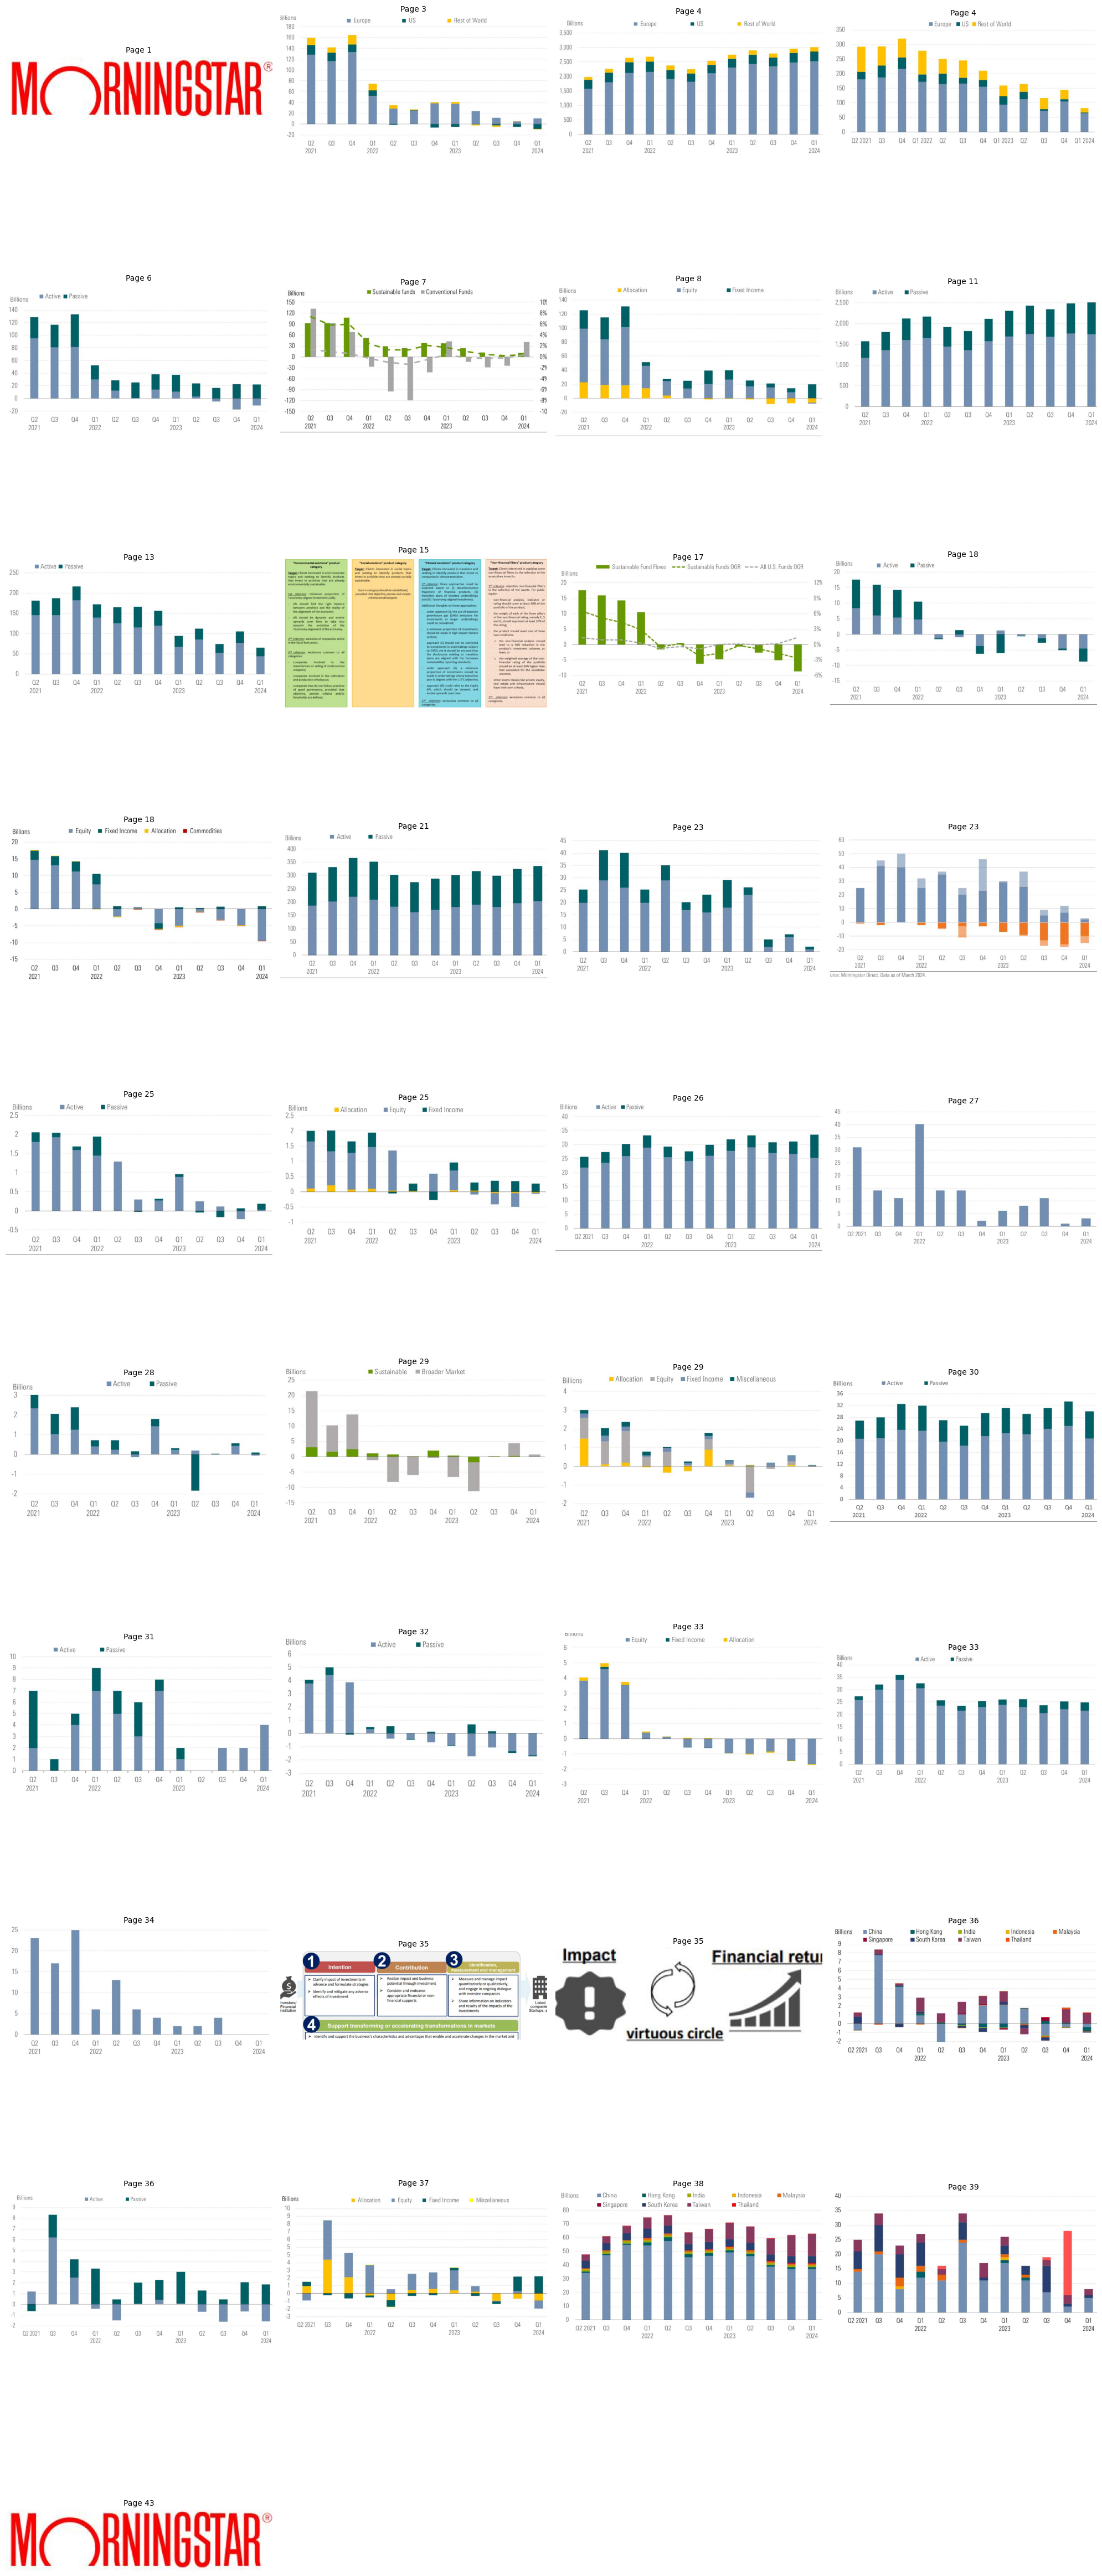

In [58]:
display_images_from_metadata(extracted_image_data)

#### 3. Extract Table Components

In [20]:
from unstructured.documents.elements import Table

In [21]:
def extract_table_metadata(esg_report, source_document):
    table_data = []
    
    for element in esg_report:
        if isinstance(element, Table):
            page_number = element.metadata.page_number
            
            # Extract table content as a string
            table_content = str(element)
            
            table_data.append({
                "source_document": source_document,
                "page_number": page_number,
                "table_content": table_content
            })
    
    return table_data

In [22]:
extracted_table_data = extract_table_metadata(esg_report_raw_data, esg_report_path)

### 4. Image and Table summarization   
Images and Tables will be described in a way that make them undertandable in a few sentences.

For both image and table, we get a description first using the corresponding prompts.

#### 1. Table summarization

In [ ]:
!pip -qqq install langchain-core
!pip -qqq install langchain-openai

In [25]:
tables_summarizer_prompt = """
As an ESG analyst for emerging markets investments, provide a concise and exact summary of the table contents. 
Focus on key ESG metrics (Environmental, Social, Governance) and their relevance to emerging markets. 
Highlight significant trends, comparisons, or outliers in the data. Identify any potential impacts on investment strategies or risk assessments. 
Avoid bullet points; instead, deliver a coherent, factual summary that captures the essence of the table for ESG investment decision-making.

Table: {table_content}

Limit your summary to 3-4 sentences, ensuring it's precise and informative for ESG analysis in emerging markets."""

In [26]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [27]:
OPENAI_API_TOKEN="YOUR TOKEN"
model_ID = "gpt-4o"
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

In [28]:
description_model = ChatOpenAI(model=model_ID)

In [29]:
def extract_table_metadata_with_summary(esg_report, 
                                        source_document, 
                                        tables_summarizer_prompt):

    table_data = []
    prompt = ChatPromptTemplate.from_template(tables_summarizer_prompt)

    for element in esg_report:
        if isinstance(element, Table):
            page_number = element.metadata.page_number
            
            # Extract table content as a string
            table_content = str(element)
            
            # Generate summary using the OpenAI model
            messages = prompt.format_messages(table_content=table_content)
            description = description_model.predict_messages(messages).content
            
            table_data.append({
                "source_document": source_document,
                "page_number": page_number,
                "table_content": table_content,
                "description": description
            })
    
    return table_data

In [30]:
extracted_table_data_with_summary = extract_table_metadata_with_summary(esg_report_raw_data, 
                                                                        esg_report_path, 
                                                                        tables_summarizer_prompt)

/Users/zoumanakeita/Desktop/Perso/Freelance/Weaviate/weaviate_venv_prod/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.predict_messages` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [31]:
for table in extracted_table_data_with_summary:
    print(f"Table on Page {table['page_number']}:")
    print(f"Table source: {table['source_document']}")
    print(f"Description: {table['description']}")
    print("---")

Table on Page 2:
Table source: ../data/Global_ESG_Q1_2024_Flows_Report.pdf
Description: The table provides a snapshot of Q1 2024 asset flows across various regions, with a notable dominance in Europe, which holds $2,513 billion in assets, representing 84% of the total, and the United States with $335 billion, or 1% of the total. Emerging markets, particularly Asia ex-Japan, show modest inflows of $0.2 billion with a total asset base of $63 billion, indicating limited but positive engagement in ESG investments. Japan's significant outflow of -$17 billion is an outlier that could signal regional ESG investment risks or disinterest. These trends highlight that while emerging markets are increasingly participating in ESG investments, they still lag far behind developed regions, impacting investment strategies by necessitating higher due diligence and risk assessment in these areas.
---
Table on Page 5:
Table source: ../data/Global_ESG_Q1_2024_Flows_Report.pdf
Description: The table reveals

In [32]:
extracted_table_data_with_summary

[{'source_document': '../data/Global_ESG_Q1_2024_Flows_Report.pdf',
  'page_number': 2,
  'table_content': 'Q1 2024 Flows Assets Funds Region USD Billion USD Billion _% Total # —_ %Total Europe 10.9 2,513 84 5,581 United States 88 335 1 630 Asia ex-Japan 0.2 63 2 606 Australia/New Zealand 0.0 30 | 261 Japan -17 25 | 233 Canada 0.2 34 1 332 Total 0.9 2,999 7,643',
  'description': "The table provides a snapshot of Q1 2024 asset flows across various regions, with a notable dominance in Europe, which holds $2,513 billion in assets, representing 84% of the total, and the United States with $335 billion, or 1% of the total. Emerging markets, particularly Asia ex-Japan, show modest inflows of $0.2 billion with a total asset base of $63 billion, indicating limited but positive engagement in ESG investments. Japan's significant outflow of -$17 billion is an outlier that could signal regional ESG investment risks or disinterest. These trends highlight that while emerging markets are increasingl

#### 2. Image summarization

In [33]:
from PIL import Image as PILImage
import base64

In [34]:
images_summarizer_prompt = """
As an ESG analyst for emerging markets investments, please provide a clear interpretation of data or information that see describe from the image. 
Focus on ESG-relevant content (Environmental, Social, Governance) and any emerging market context. Describe the type of visual (e.g., chart, photograph, infographic) and its key elements. 
Highlight significant data points or trends that are relevant to investment analysis. Avoid bullet points; instead, deliver a coherent, factual summary that captures the essence of the image for ESG investment decision-making.

Image: {image_element}

Limit your description to 3-4 sentences, ensuring it's precise and informative for ESG analysis."""

In [35]:
def extract_image_metadata_with_summary(esg_report_raw_data, 
                                        esg_report_path, 
                                        images_summarizer_prompt):

    image_data = []
    
    # Create ChatPromptTemplate instance
    prompt = ChatPromptTemplate.from_template(images_summarizer_prompt)
    
    # Create ChatOpenAI instance
    description_model = ChatOpenAI(model=model_ID) 
    
    for element in esg_report_raw_data:
        if "Image" in str(type(element)):
            page_number = element.metadata.page_number if hasattr(element.metadata, 'page_number') else None
            image_path = element.metadata.image_path if hasattr(element.metadata, 'image_path') else None
            
            if image_path and os.path.exists(image_path):
                # Generate description using the OpenAI model
                messages = prompt.format_messages(image_element=image_path)
                description = description_model.predict_messages(messages).content
                
                # Read the image file and encode it to base64
                with open(image_path, "rb") as image_file:
                    encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
                
                image_data.append({
                    "source_document": esg_report_path,
                    "page_number": page_number,
                    "image_path": image_path,
                    "description": description,
                    "base64_encoding": encoded_string
                })
            else:
                print(f"Warning: Image file not found or path not available for image on page {page_number}")
    
    return image_data

In [36]:
extracted_image_data = extract_image_metadata_with_summary(esg_report_raw_data,
                                                           esg_report_path,
                                                           images_summarizer_prompt)

In [37]:
for image in extracted_image_data:
    print(f"Image on Page {image['page_number']}:")
    print(f"Path: {image['image_path']}")
    print(f"Description: {image['description']}")
    print(f"Base 64: {image['base64_encoding']}")
    print("---")

Image on Page 1:
Path: ../data/images/figure-1-1.jpg
Description: The visual appears to be a bar chart illustrating the carbon emissions of various companies in an emerging market, segmented by industry. The key elements include bars representing emissions levels, with color coding to differentiate sectors such as energy, manufacturing, and technology. Notably, the energy sector shows significantly higher emissions compared to others, indicating potential environmental risks. This trend underscores the need for stringent environmental policies and sustainable practices in the energy sector to mitigate ESG risks for investors focusing on reducing their carbon footprint in emerging markets.
Base 64: /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABcAYUDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDA

In [38]:
print(extracted_image_data[1]["description"])

The image appears to be a bar chart illustrating the carbon emissions of various emerging market countries over a decade. Key elements include color-coded bars representing annual emissions and a trend line indicating an overall increase or decrease in emissions. Notably, countries like India and Brazil show a significant upward trend in their emissions, which highlights potential environmental risks and regulatory challenges. This data is crucial for ESG investment analysis as it underscores the need for robust environmental policies and sustainable practices to mitigate long-term risks in these markets.


## Data Upload

### 0. Connect to the Weaviate instance

In [ ]:
!pip -qqq install weaviate-client

In [82]:
import weaviate
  
# Set these environment variables
URL = os.getenv("WCS_URL")
APIKEY = os.getenv("WCS_API_KEY")


# Connect to a WCS instance
client = weaviate.connect_to_wcs(
    cluster_url=URL,
    auth_credentials=weaviate.auth.AuthApiKey(APIKEY),
    headers = {
        "X-OpenAI-Api-Key": OPENAI_API_TOKEN
    }
)

In [41]:
client

### 1. Set Up Weaviate Vector Database

In [ ]:
# Install libraries
#!pip install -U weaviate-client

### 2. Create Multimodal ESG Collection

In [83]:
import weaviate.classes.config as wc

properties = [
    wc.Property(name="source_document", data_type=wc.DataType.TEXT, skip_vectorization=True),
    wc.Property(name="page_number", data_type=wc.DataType.INT, skip_vectorization=True),
    wc.Property(name="paragraph_number", data_type=wc.DataType.INT, skip_vectorization=True),
    wc.Property(name="text", data_type=wc.DataType.TEXT),
    wc.Property(name="image_path", data_type=wc.DataType.TEXT, skip_vectorization=True),
    wc.Property(name="description", data_type=wc.DataType.TEXT),
    wc.Property(name="base64_encoding", data_type=wc.DataType.BLOB, skip_vectorization=True),
    wc.Property(name="table_content", data_type=wc.DataType.TEXT),
    wc.Property(name="url", data_type=wc.DataType.TEXT, skip_vectorization=True),
    wc.Property(name="audio_path", data_type=wc.DataType.TEXT, skip_vectorization=True),
    wc.Property(name="transcription", data_type=wc.DataType.TEXT),
    wc.Property(name="content_type", data_type=wc.DataType.TEXT, skip_vectorization=True),
]

In [84]:
client.collections.create(
    name="ESGDocuments",
    properties=properties,
    vectorizer_config=None
)

### 3. Data Ingestion 
#### Helper functions

In [85]:
# Initialize OpenAI client
from weaviate.util import generate_uuid5
from tqdm import tqdm
from openai import OpenAI
openai_client = OpenAI()

In [86]:
# Function to get embeddings
def get_embedding(text):
    response = openai_client.embeddings.create(
        input=text,
        model="text-embedding-3-large"
    )
    return response.data[0].embedding

# Ingestion functions
def ingest_audio_data(collection, audio_data):
    with collection.batch.dynamic() as batch:
        for audio in tqdm(audio_data, desc="Ingesting audio data"):
            vector = get_embedding(audio['transcription'])
            audio_obj = {
                "url": audio['url'],
                "audio_path": audio['audio_path'],
                "transcription": audio['transcription'],
                "content_type": "audio"
            }
            batch.add_object(
                properties=audio_obj,
                uuid=generate_uuid5(audio['url']),
                vector=vector
            )

def ingest_text_data(collection, text_data):
    with collection.batch.dynamic() as batch:
        for text in tqdm(text_data, desc="Ingesting text data"):
            vector = get_embedding(text['text'])
            text_obj = {
                "source_document": text['source_document'],
                "page_number": text['page_number'],
                "paragraph_number": text['paragraph_number'],
                "text": text['text'],
                "content_type": "text"
            }
            batch.add_object(
                properties=text_obj,
                uuid=generate_uuid5(f"{text['source_document']}_{text['page_number']}_{text['paragraph_number']}"),
                vector=vector
            )

def ingest_image_data(collection, image_data):
    with collection.batch.dynamic() as batch:
        for image in tqdm(image_data, desc="Ingesting image data"):
            vector = get_embedding(image['description'])
            image_obj = {
                "source_document": image['source_document'],
                "page_number": image['page_number'],
                "image_path": image['image_path'],
                "description": image['description'],
                "base64_encoding": image['base64_encoding'],
                "content_type": "image"
            }
            batch.add_object(
                properties=image_obj,
                uuid=generate_uuid5(f"{image['source_document']}_{image['page_number']}_{image['image_path']}"),
                vector=vector
            )

def ingest_table_data(collection, table_data):
    with collection.batch.dynamic() as batch:
        for table in tqdm(table_data, desc="Ingesting table data"):
            vector = get_embedding(table['description'])
            table_obj = {
                "source_document": table['source_document'],
                "page_number": table['page_number'],
                "table_content": table['table_content'],
                "description": table['description'],
                "content_type": "table"
            }
            batch.add_object(
                properties=table_obj,
                uuid=generate_uuid5(f"{table['source_document']}_{table['page_number']}"),
                vector=vector
            )

def ingest_all_data(collection_name, audio_data, text_data, image_data, table_data):

    collection = client.collections.get(collection_name)

    ingest_audio_data(collection, audio_data)
    ingest_text_data(collection, text_data)
    ingest_image_data(collection, image_data)
    ingest_table_data(collection, table_data)

    if len(collection.batch.failed_objects) > 0:
        print(f"Failed to import {len(collection.batch.failed_objects)} objects")
    else:
        print("All objects imported successfully")

#### Start data ingestion

In [87]:
ingest_all_data(collection_name="ESGDocuments", 
                audio_data=audio_data, 
                text_data=extracted_data, 
                image_data=extracted_image_data, 
                table_data=extracted_table_data_with_summary
            )

Ingesting table data: 100%|██████████| 13/13 [00:02<00:00,  4.37it/s]

All objects imported successfully


### 3. Vector database query for most relevant data

In [47]:
import weaviate.classes.query as wq

In [77]:

def search_multimodal(query: str, limit: int = 3):
    query_vector = get_embedding(query)
    
    esg_documents = client.collections.get("ESGDocuments")
    
    response = esg_documents.query.near_vector(
        near_vector=query_vector,
        limit=limit,
        return_metadata=wq.MetadataQuery(distance=True),
        return_properties=[
            "content_type", "url", "audio_path", "transcription",
            "source_document", "page_number", "paragraph_number", "text",
            "image_path", "description", "table_content"
        ]
    )
    
    return response.objects

In [ ]:
!pip -qqq install textwrap3

In [50]:
import textwrap

def wrap_text(text, width=120):

    wrapped_text = textwrap.fill(text, width=width)
    
    return wrapped_text

In [73]:
def search_and_print_results(query, limit=3):
    
    search_results = search_multimodal(query, limit)

    print(f"Search Results for query: '{query}'")
    for item in search_results:
        print(f"Type: {item.properties['content_type']}")
        if item.properties['content_type'] == 'audio':
            print(f"URL: {item.properties['url']}")
            print(f"Transcription: {item.properties['transcription'][:100]}...")
        elif item.properties['content_type'] == 'text':
            print(f"Source: {item.properties['source_document']}, Page: {item.properties['page_number']}")
            print(f"Paragraph {item.properties['paragraph_number']}")
            print(f"Text: {item.properties['text'][:100]}...")
        elif item.properties['content_type'] == 'image':
            print(f"Source: {item.properties['source_document']}, Page: {item.properties['page_number']}")
            print(f"Description: {item.properties['description']}")
        elif item.properties['content_type'] == 'table':
            print(f"Source: {item.properties['source_document']}, Page: {item.properties['page_number']}")
            print(f"Description: {item.properties['description']}")
        print(f"Distance to query: {item.metadata.distance:.3f}")
        print("---")

In [90]:
query = "What are the main environmental challenges in renewable energy?"
search_and_print_results(query)

Search Results for query: 'What are the main environmental challenges in renewable energy?'
Type: image
Source: ../data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 23
Description: The image appears to be a bar chart highlighting the renewable energy adoption rates among various emerging market countries over the past decade. It shows a significant upward trend, with countries like India, Brazil, and China leading in the percentage of their energy derived from renewable sources. The chart underscores a marked increase in investment towards sustainable energy infrastructure, reflecting a growing commitment to environmental sustainability. This trend is crucial for ESG investment analysis as it indicates a positive shift towards reducing carbon footprints and enhancing long-term environmental resilience in these markets.
Distance to query: 0.597
---
Type: image
Source: ../data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 36
Description: The image appears to be an infographic depicting the di

### 3. Multimodal RAG for ESG

In [91]:
def generate_response(query: str, context: str) -> str:
    prompt = f"""
    You are an AI assistant specializing in ESG (Environmental, Social, and Governance) analysis for emerging markets. 
    Use the following pieces of information to answer the user's question. 
    If you cannot answer the question based on the provided information, say that you don't have enough information to answer accurately.

    Context:
    {context}

    User Question: {query}

    Please provide a detailed and accurate answer based on the given context:
    """

    response = openai_client.chat.completions.create(
        model="gpt-4-1106-preview",
        messages=[
            {"role": "system", "content": "You are an expert ESG analyst for emerging markets."},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )

    return response.choices[0].message.content

In [92]:
def esg_analysis(user_query: str):
    # Step 1: Retrieve relevant information
    search_results = search_multimodal(user_query)

    # Step 2: Prepare context for RAG
    context = ""
    for item in search_results:
        if item.properties['content_type'] == 'audio':
            context += f"Audio Transcription from {item.properties['url']}: {item.properties['transcription']}\n\n"
        elif item.properties['content_type'] == 'text':
            context += f"Text from {item.properties['source_document']} (Page {item.properties['page_number']}, Paragraph {item.properties['paragraph_number']}): {item.properties['text']}\n\n"
        elif item.properties['content_type'] == 'image':
            context += f"Image Description from {item.properties['source_document']} (Page {item.properties['page_number']}, Path: {item.properties['image_path']}): {item.properties['description']}\n\n"
        elif item.properties['content_type'] == 'table':
            context += f"Table Description from {item.properties['source_document']} (Page {item.properties['page_number']}): {item.properties['description']}\n\n"

    # Step 3: Generate response using RAG
    response = generate_response(user_query, context)

    # Step 4: Format and return the final output
    sources = []
    for item in search_results:
        source = {
            "type": item.properties["content_type"],
            "distance": item.metadata.distance
        }
        if item.properties["content_type"] == 'text':
            source.update({
                "document": item.properties["source_document"],
                "page": item.properties["page_number"],
                "paragraph": item.properties["paragraph_number"]
            })
        elif item.properties["content_type"] == 'image':
            source.update({
                "document": item.properties["source_document"],
                "page": item.properties["page_number"],
                "image_path": item.properties["image_path"]
            })
        elif item.properties["content_type"] == 'table':
            source.update({
                "document": item.properties["source_document"],
                "page": item.properties["page_number"]
            })
        elif item.properties["content_type"] == 'audio':
            source.update({
                "url": item.properties["url"]
            })
        sources.append(source)

    # Sort sources by distance (ascending order)
    sources.sort(key=lambda x: x['distance'])

    final_output = {
        "user_query": user_query,
        "ai_response": response,
        "sources": sources
    }

    return final_output

In [93]:
def analyze_and_print_esg_results(user_question):
    result = esg_analysis(user_question)

    print("User Query:", result["user_query"])
    print("\nAI Response:", wrap_text(result["ai_response"]))
    print("\nSources (sorted by relevance):")
    for source in result["sources"]:
        print(f"- Type: {source['type']}, Distance: {source['distance']:.3f}")
        if source['type'] == 'text':
            print(f"  Document: {source['document']}, Page: {source['page']}, Paragraph: {source['paragraph']}")
        elif source['type'] == 'image':
            print(f"  Document: {source['document']}, Page: {source['page']}, Image Path: {source['image_path']}")
        elif source['type'] == 'table':
            print(f"  Document: {source['document']}, Page: {source['page']}")
        elif source['type'] == 'audio':
            print(f"  URL: {source['url']}")
        print("---")

In [94]:
user_question = "Is ESG investment a fraud?"
analyze_and_print_esg_results(user_question)

User Query: Is ESG investment a fraud?

AI Response: Based on the provided context, it is not accurate to categorically state that ESG investment is a fraud. The term
"fraud" implies intentional deception for personal or financial gain, and while the audio transcription from the YouTube
video expresses a strong opinion that ESG marketing can be misleading and that some practices within the ESG space may
lack substance ("a lot of sizzle, no steak"), it does not provide evidence that the entire field of ESG investment is
fraudulent.  The speaker in the audio transcription does raise concerns about the effectiveness and sincerity of some
ESG claims, particularly around the use of carbon credits and the motivations behind certain corporate statements on
ESG. They suggest that some companies may be using ESG as a marketing tool or as a means to access favorable financing,
such as borrowing at negative rates from the European Central Bank (ECB). However, the speaker also acknowledges the
imp

In [330]:
user_question = "What was the total net inflow for global sustainable funds in Q1 2024?"
analyze_and_print_esg_results(user_question)

User Query: What was the total net inflow for global sustainable funds in Q1 2024?

AI Response: The total net inflow for global sustainable funds in Q1 2024 was close to USD 900 million. This information is directly
provided in the text from the Global ESG Q1 2024 Flows Report (Page 2, Paragraph 4), which states that "the global
universe of sustainable funds netted close to USD 900 million" in the first quarter of 2024.

Sources (sorted by relevance):
- Type: text, Distance: 0.220
  Document: ../data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 2, Paragraph: 6
---
- Type: text, Distance: 0.227
  Document: ../data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 6, Paragraph: 2
---
- Type: text, Distance: 0.230
  Document: ../data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 2, Paragraph: 4
---


In [331]:
user_question = "How did European sustainable fund flows perform in Q1 2024 compared to the previous quarter?"
analyze_and_print_esg_results(user_question)

User Query: How did European sustainable fund flows perform in Q1 2024 compared to the previous quarter?

AI Response: In the first quarter of 2024, European sustainable funds experienced an increase in subscriptions compared to the
previous quarter. Specifically, inflows amounted to USD 10.9 billion in Q1 2024, which is more than double the restated
inflows of USD 4.9 billion in Q4 2023. However, it's important to note that actively managed sustainable fund strategies
saw outflows, reaching USD 11 billion in Q1 2024, although this was an improvement from the restated USD 17.5 billion
outflows in the previous quarter. Passive sustainable investment strategies continued to attract approximately the same
level of inflows as the previous quarter, around USD 22 billion, indicating a sustained preference for passive over
active strategies.  In terms of asset classes within sustainable funds, equity funds, which are traditionally strong,
experienced a downturn with outflows totaling USD 1.3 

In [332]:
user_question = "How many new sustainable funds were launched globally in Q1 2024?"
analyze_and_print_esg_results(user_question)

User Query: How many new sustainable funds were launched globally in Q1 2024?

AI Response: In the first quarter of 2024, there were 97 new sustainable funds launched globally. This information is taken from the
text on page 4, paragraph 2 of the Global ESG Q1 2024 Flows Report, which states that the decline in global fund
launches continued, reaching an unprecedented low of 97 new sustainable funds introduced worldwide. However, it is
important to note that this number is likely to be restated upward in the next report as more launches are identified
and additional ones are reported to Morningstar.

Sources (sorted by relevance):
- Type: text, Distance: 0.195
  Document: ../data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 12, Paragraph: 3
---
- Type: text, Distance: 0.201
  Document: ../data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 4, Paragraph: 2
---
- Type: text, Distance: 0.202
  Document: ../data/Global_ESG_Q1_2024_Flows_Report.pdf, Page: 31, Paragraph: 2
---


In [333]:
user_question = "What is the net flows for Parnassus Mid Cap Fund?"
analyze_and_print_esg_results(user_question)

User Query: What is the net flows for Parnassus Mid Cap Fund?

AI Response: Based on the information provided from the Global ESG Q1 2024 Flows Report, the Parnassus Mid Cap Fund (PARMX)
experienced significant net outflows. Specifically, it is mentioned that Parnassus Mid Cap fell to second place in terms
of the worst net withdrawals, shedding almost USD 2 billion during the period. However, the exact net flow figure for
the Parnassus Mid Cap Fund is not provided in the excerpts you have shared.  To give a precise figure for the net flows
of the Parnassus Mid Cap Fund, we would need additional data that states the total inflows and outflows for the fund,
from which we could calculate the net flows (net flows = total inflows - total outflows). The provided text only
mentions the outflows and does not provide information on any inflows that the fund might have had. Therefore, with the
information at hand, I don't have enough information to answer accurately the net flows for the Parnass

## Clean workspace

In [ ]:
# This command will delete the collection named "ESGDocuments" from your Weaviate instance.
client.collections.delete("ESGDocuments")